# Predictive Modeling: Tanzanian Water Wells

## Business Understanding

### Overview

This project uses data on various water wells in Tanzania and attempts to build a predictive model that can discern between operational and non-operational water wells. The data contains information on each water well such as longitude, latitude, funder, management, pump type, and much more. The Tanzanian government can use this analysis and predictive model in order to decide where to allocate funding for water wells.

### Business Problem

Tanzania is a developing country with a population of over 57 million people. This country struggles to provide its large population with clean water. However, there are many water wells throughout the country. The Tanzanian government needs a way to predict if these water wells are operational or non-operational. Due to the nature of this problem, predicting a water well is operational when in reality it is not, is more costly than predicting a water well is non-operational when in reality it is. 
## Data Understanding

### Data Sources

The data used for this project comes from [DrivenData](https://www.drivendata.org/) and can be downloaded [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/).

## Data Preparation

### Data Cleaning

In [142]:
#Importing everything needed
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from missingpy import MissForest
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
#Loading in the data as DataFrames
training_labels = pd.read_csv('../Data/training_set_labels.csv')
training_values = pd.read_csv('../Data/training_set_values.csv')

### Turning a Ternary Classification Problem into a Binary Classification Problem

`status_group` is the target group. As the data is given there are 3 possible values in this column:
1. functional
2. functional needs repair
3. non functional

According to the descriptions of these values, 'functional' and 'functional needs repair' are both considered to be operational while 'non functional' is considered non-operational. Therefore, it was decided to group 'functional' and 'functional needs repair' under operational. Leaving 'non functional' on its own and now labeled as non-operational.

In [144]:
training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [145]:
#Changes the values in the 'status_group' column
training_labels['status_group'] = training_labels['status_group'].map({
                                                                        'non functional': 'non operational', 
                                                                        'functional': 'operational', 
                                                                         'functional needs repair': 'operational'})

### Merging `training_labels` with `training_values`

The data was downloaded in 2 different files. `training_labels` contains a unique identifier and the target column 'status_group'. `training_values` contains a matching unique identifier column along with the rest of the data. The data needs to be merged in order to perform a proper train/test split later.

In [146]:
#Showing a preview of 'training_labels' after the values have been changed
training_labels.head()

,id,status_group
0,69572,operational
1,8776,operational
2,34310,operational
3,67743,non operational
4,19728,operational


In [147]:
#Showing a preview of 'training_values'
training_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [148]:
#Merging on the two DataFrames on 'id'
df = training_values.merge(training_labels, on='id')

### Dropping Unnecessary/Unusable Columns
These columns were dropped because they either had too many null values, placeholder values, or was missing information to give the values meaning.

In [149]:
#Dropping the unique identifier column
df.drop("id", axis = 1,inplace=True)

In [150]:
#Creating a list of all the columns to drop from the DataFrame
columns_to_drop = ["amount_tsh", "num_private", "recorded_by", "payment_type", "extraction_type", "extraction_type_group", 
                   "water_quality", "quantity_group", "scheme_name"]
#Dropping all the columns from the DataFrame using the list above
df_small = df.drop(columns_to_drop, axis = 1)

### Replacing all Placeholder Values with Null Values

There were many columns with placeholder values such as 0 or 'none'. These were replaced with null values in order to be imputed later.

In [151]:
#Replacing all placeholder values with null values
df_small_small = df_small.replace({'none': None,'unknown' : None, -2.00E-08: None, "0": None})
df_small_small["district_code"].replace({0: None}, inplace=True)
df_small_small["population"].replace({0: None}, inplace=True)
df_small_small["construction_year"].replace({0: None}, inplace=True)

Decided it is not a good idea to impute values for longitude or latitude and there are some null values in the latitude column. It is not a large amount of data lost if theses nulls are removed from the data so they were removed.

In [152]:
#Finding the amount of nulls in the latitude column
df_small_small['latitude'].isna().sum()

1812

In [153]:
#Dropping the nulls from latitude
df_small_small.dropna(subset=['latitude'],inplace=True)

### Creating copy of DataFrame for Further Cleaning

In [154]:
df_smallest = df_small_small.copy()

### Reducing Funder

In [155]:
funder_30 = list(df_small_small['funder'].value_counts().head(30).index)
df_smallest = df_smallest[df_smallest['funder'].isin(funder_30)]

### Reducing Installer

In [156]:
installer_30 = list(df_smallest['installer'].value_counts().head(30).index)
df_smallest = df_smallest[df_smallest['installer'].isin(installer_30)]

### Dropping wpt_name

In [157]:
df_smallest = df_smallest.drop('wpt_name', axis=1)

### Basin - Good

In [158]:
df_smallest['basin'].value_counts()

Pangani                    4704
Lake Victoria              4589
Rufiji                     3595
Lake Tanganyika            3334
Internal                   2538
Lake Rukwa                 1760
Lake Nyasa                 1760
Ruvuma / Southern Coast    1609
Wami / Ruvu                1335
Name: basin, dtype: int64

### Subvillage - drop

In [159]:
df_smallest = df_smallest.drop('subvillage', axis=1)

In [160]:
df_smallest.columns

Index(['date_recorded', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'management',
       'management_group', 'payment', 'quality_group', 'quantity', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

### Region - Good

In [161]:
df_smallest['region'].value_counts()

Shinyanga      2575
Iringa         2421
Kilimanjaro    2188
Mbeya          1999
Kigoma         1674
Ruvuma         1536
Kagera         1523
Mwanza         1376
Arusha         1355
Morogoro       1346
Tanga          1228
Rukwa           945
Tabora          907
Mara            884
Dodoma          789
Pwani           783
Manyara         496
Lindi           463
Mtwara          425
Singida         311
Name: region, dtype: int64

### region_code -  drop codes 60 and 4

In [162]:
df_smallest['region_code'].value_counts()

17    2574
11    2422
3     2188
12    1999
16    1674
10    1536
18    1525
19    1376
2     1355
5     1346
4     1228
15     945
14     907
20     884
1      789
6      538
21     496
80     454
90     416
13     311
60     245
9        9
8        7
Name: region_code, dtype: int64

In [163]:
df_smallest = df_smallest.loc[~((df_smallest['region_code'] == 8) | (df_smallest['region_code'] == 60))]

### District Code - drop 80 and 63

In [164]:
df_smallest['district_code'].value_counts()

2     5560
1     5453
3     4636
4     3356
5     1767
6     1669
7      929
33     402
8      387
30     336
13     289
23     104
43      61
63      14
80       2
Name: district_code, dtype: int64

In [165]:
df_smallest = df_smallest.loc[~((df_smallest['district_code'] == 80) | (df_smallest['district_code'] == 63))]

### lga - drop

In [166]:
df_smallest = df_smallest.drop('lga', axis=1)

### ward - drop

In [167]:
df_smallest = df_smallest.drop('ward', axis=1)

### public meeting - good

In [168]:
df_smallest['public_meeting'].value_counts()

True     21399
False     2379
Name: public_meeting, dtype: int64

### scheme management - good

In [169]:
df_smallest['scheme_management'].value_counts()

VWC                 15124
WUG                  2498
Water authority      1779
WUA                  1302
Water Board          1045
Company               538
Parastatal            368
Other                 242
Private operator       62
Trust                   8
Name: scheme_management, dtype: int64

### Permit - good

In [170]:
df_smallest['permit'].value_counts()

True     17562
False     7102
Name: permit, dtype: int64

### Extraction type class - good

In [171]:
df_smallest['extraction_type_class'].value_counts()

gravity         12507
handpump         7519
other            2568
submersible      1378
motorpump         874
rope pump          97
wind-powered       13
Name: extraction_type_class, dtype: int64

### management - good

In [172]:
df_smallest['management'].value_counts()

vwc                 17144
wug                  3176
water board          1262
wua                  1065
private operator      586
water authority       486
parastatal            414
other                 319
company               272
trust                   8
Name: management, dtype: int64

### management group - good

In [173]:
df_smallest['management_group'].value_counts()

user-group    22647
commercial     1352
parastatal      414
other           319
Name: management_group, dtype: int64

### payment - good

In [174]:
df_smallest['payment'].value_counts()

never pay                10484
pay monthly               3984
pay per bucket            2688
pay when scheme fails     2152
pay annually              1822
other                      665
Name: payment, dtype: int64

### quality group - good

In [175]:
df_smallest['quality_group'].value_counts()

good        22222
salty        1699
milky         473
colored       126
fluoride       60
Name: quality_group, dtype: int64

### quantity - good

In [176]:
df_smallest['quantity'].value_counts()

enough          14119
insufficient     6591
dry              2556
seasonal         1470
Name: quantity, dtype: int64

### source - good

In [177]:
df_smallest['source'].value_counts()

spring                  8312
shallow well            7501
river                   4116
machine dbh             3325
rainwater harvesting     666
hand dtw                 416
lake                     290
dam                      266
other                     36
Name: source, dtype: int64

### source type - drop

In [178]:
df_smallest['source_type'].value_counts()

spring                  8312
shallow well            7501
river/lake              4406
borehole                3741
rainwater harvesting     666
dam                      266
other                     64
Name: source_type, dtype: int64

In [179]:
df_smallest = df_smallest.drop('source_type', axis=1)

### source class - good

In [180]:
df_smallest['source_class'].value_counts()

groundwater    19554
surface         5338
Name: source_class, dtype: int64

### waterpoint type - drop

In [181]:
df_smallest['waterpoint_type'].value_counts()

communal standpipe             11353
hand pump                       7928
other                           2777
communal standpipe multiple     2552
improved spring                  283
cattle trough                     60
dam                                3
Name: waterpoint_type, dtype: int64

In [182]:
df_smallest = df_smallest.drop('waterpoint_type', axis=1)

### waterpoint type group - drop dam and cattle trough

In [183]:
df_smallest['waterpoint_type_group'].value_counts()

communal standpipe    13905
hand pump              7928
other                  2777
improved spring         283
cattle trough            60
dam                       3
Name: waterpoint_type_group, dtype: int64

In [184]:
df_smallest = df_smallest.loc[~((df_smallest['waterpoint_type_group'] == 'dam') |
                                (df_smallest['waterpoint_type_group'] == 'cattle trough'))]

### Preparing Data for Imputation
MissForest is the imputer used for this project. MissForest can handle categorical data but the values must be numbers. Strings will not pass through the imputer. There is a lot of categorical data with strings as values. We created a function that turns these strings into an integer that corresponds to its rank in a .value_counts() in order to pass it through the MissForest imputer.

In [185]:
df_smallest['funder'].value_counts()

Government Of Tanzania    7501
Danida                    2868
Hesawa                    1868
Kkkt                      1117
Rwssp                      995
World Vision               880
Unicef                     812
Dhv                        794
Tasaf                      640
Germany Republi            610
Tcrs                       575
Norad                      569
District Council           567
Netherlands                455
Water                      445
Hifab                      444
Lga                        431
Private Individual         394
Dwe                        387
Adb                        379
Dwsp                       357
Oxfam                      341
World Bank                 320
Rudep                      291
Ministry Of Water          274
Wateraid                   201
Amref                      191
Isf                        178
Rc Church                    9
Name: funder, dtype: int64

In [186]:
df_smallest.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,...,extraction_type_class,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type_group,status_group
6,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Internal,Shinyanga,17,3,...,handpump,vwc,user-group,never pay,good,enough,machine dbh,groundwater,hand pump,non operational
7,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Lake Tanganyika,Shinyanga,17,3,...,handpump,wug,user-group,None,milky,enough,shallow well,groundwater,hand pump,non operational
11,2013-02-18,Danida,1062,DANIDA,35.770258,-10.574175,Lake Nyasa,Ruvuma,10,5,...,handpump,wug,user-group,pay when scheme fails,good,insufficient,shallow well,groundwater,hand pump,operational
12,2012-10-14,World Vision,0,World vision,33.798106,-3.290194,Internal,Shinyanga,17,2,...,handpump,wug,user-group,other,good,enough,shallow well,groundwater,hand pump,operational
15,2011-08-04,Rudep,1645,DWE,31.444121,-8.274962,Lake Tanganyika,Rukwa,15,2,...,handpump,vwc,user-group,never pay,good,enough,machine dbh,groundwater,hand pump,operational


In [187]:
# this function takes columns from the df and turns the value into numbers in order to impute nulls with MissForest
def transform_columns(dataframe, columns):
    #creating new df that will have integers instead of strings for values
    transformed_df = pd.DataFrame()
    
    #loops through each column in the df given and assigns the strings an integer based off the rank in .value_counts()
    for column in columns:
        unique_vals = dataframe[column].value_counts().index
        string_to_numbers = dataframe[column].replace(to_replace=unique_vals, value=list(range(len(unique_vals))))
        transformed_df[column] = string_to_numbers
        
    return transformed_df

### Using the Function

Running the function in the cell below takes a few minutes so we saved it as a .csv file in order to quickly access it.
The below cell is commented out but shows where `transformed_df` is coming from and can be ran if needed.

In [188]:
#Using the function above on all categorical columns

transformed_df = transform_columns(df_smallest, ['funder', 'installer', 'basin', 'region', 
                                                    'region_code', 'district_code', 'public_meeting', 
                                                    'scheme_management', 'permit', 'extraction_type_class',
                                                    'management', 'management_group', 'payment', 'quality_group', 
                                                    'quantity', 'source', 'source_class',
                                                    'waterpoint_type_group', 'status_group'])

### .csv File

working_df.csv is the file saved from `transformed_df`

In [189]:
#Loading in working_df.csv as transformed_df
#transformed_df = pd.read_csv('../Dev_Notebooks/working_df.csv')
#transformed_df

### Removing Extra Column

When saving it, there was an exta column added in the beginning that needs to be dropped.

In [190]:
#Dropping unnecessary column
#transformed_df = transformed_df.drop('Unnamed: 0', axis=1)
transformed_df

,funder,installer,basin,region,region_code,district_code,public_meeting,scheme_management,permit,extraction_type_class,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type_group,status_group
6,20,27,4,0,0,2.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1,1
7,4,0,3,0,0,2.0,0.0,NaN,0.0,1,1.0,0.0,NaN,2.0,0.0,1.0,0.0,1,1
11,1,2,6,5,5,4.0,0.0,1.0,1.0,1,1.0,0.0,3.0,0.0,1.0,1.0,0.0,1,0
12,5,14,4,0,0,0.0,0.0,1.0,1.0,1,1.0,0.0,5.0,0.0,0.0,1.0,0.0,1,0
15,23,0,3,11,11,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59386,19,0,5,11,11,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1,0
59390,23,0,3,11,11,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1,0
59391,0,1,0,2,2,2.0,0.0,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0,1
59392,0,1,5,3,3,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


### Combining all Columns into `transformed_df`

Now that the categorical columns have been changed to numbers, the numerical columns can be merged back into the same DataFrame.

In [191]:
#Adding all numerical columns onto 'transformed_df'
transformed_df['date_recorded'] = df_smallest['date_recorded']
transformed_df['gps_height'] = df_smallest['gps_height']
transformed_df['longitude'] = df_smallest['longitude']
transformed_df['latitude'] = df_smallest['latitude']
transformed_df['population'] = df_smallest['population']
transformed_df['construction_year'] = df_smallest['construction_year']

### turning date recorded to year only

In [192]:
transformed_df['date_recorded'] = pd.to_datetime(transformed_df['date_recorded'])

In [193]:
transformed_df['date_recorded'] = transformed_df['date_recorded'].dt.strftime('%Y')

### The Data is Clean and Ready for Train/Test Split

For the split the target column is 'status_group' and will be used for `y`. All other columns will be used as featues and will be set to `X`. A random state of 33 is used and a test size slightly larger than defualt at 0.3.

In [194]:
#Splitting the column into the target and features
X = transformed_df.drop('status_group', axis=1)
y = transformed_df['status_group']

#Creating the 4 different groups resulting from a train/test split with a test size of 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.3)

### Now the Data is Split, It's Time for the Imputer


In [195]:
#Instantiate the MissForest
imputer = MissForest(random_state=33, max_depth=5)

### Imputing `X_train`


In [196]:
#The cat_vars parameter is telling MissForest which columns are categorical

X_train_imputed = imputer.fit(X_train, cat_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
X_train_imputed = imputer.transform(X_train)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [197]:
#Loading in the saved .csv file as X_train_imputed
#X_train_imputed = pd.read_csv('../Dev_Notebooks/X_train_imputed.csv')
X_train_imputed

array([[ 1.00000000e+00,  2.00000000e+00,  6.00000000e+00, ...,
        -1.05834403e+01,  3.00000000e+02,  1.98700000e+03],
       [ 1.00000000e+00,  2.00000000e+00,  3.00000000e+00, ...,
        -4.32193779e+00,  5.40000000e+02,  2.00600000e+03],
       [ 2.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -2.52041735e+00,  5.95240644e+02,  1.98559386e+03],
       ...,
       [ 2.20000000e+01,  6.00000000e+00,  8.00000000e+00, ...,
        -6.09122965e+00,  2.10203755e+02,  1.99558391e+03],
       [ 5.00000000e+00,  1.40000000e+01,  4.00000000e+00, ...,
        -3.34350769e+00,  6.35738972e+02,  1.99861038e+03],
       [ 2.00000000e+00,  1.10000000e+01,  1.00000000e+00, ...,
        -2.53039654e+00,  3.86754728e+02,  1.98559479e+03]])

In [198]:
X_train_imputed = pd.DataFrame(X_train_imputed)
X_train_imputed

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.0,2.0,6.0,5.0,5.0,4.0,0.0,1.0,1.0,2.0,...,2.0,1.0,0.0,2.0,2013.0,1094.0,35.793151,-10.583440,300.000000,1987.000000
1,1.0,2.0,3.0,4.0,4.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,1.0,0.0,2013.0,1416.0,30.076793,-4.321938,540.000000,2006.000000
2,2.0,0.0,1.0,7.0,7.0,0.0,0.0,6.0,0.0,0.0,...,2.0,4.0,1.0,0.0,2011.0,0.0,33.483571,-2.520417,595.240644,1985.593858
3,0.0,3.0,0.0,10.0,10.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,2011.0,295.0,38.536401,-5.006737,75.000000,1972.000000
4,2.0,0.0,1.0,13.0,13.0,3.0,0.0,1.0,1.0,2.0,...,0.0,1.0,0.0,2.0,2012.0,1281.0,33.964612,-1.997276,250.000000,1989.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17420,0.0,0.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2013.0,976.0,36.841507,-3.493668,150.000000,1989.032690
17421,19.0,0.0,2.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,...,0.0,2.0,1.0,0.0,2011.0,1366.0,35.083920,-9.068121,50.000000,2008.000000
17422,22.0,6.0,8.0,14.0,14.0,4.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,2011.0,0.0,35.911264,-6.091230,210.203755,1995.583915
17423,5.0,14.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,2012.0,0.0,33.862909,-3.343508,635.738972,1998.610383


### Dropping Unnecessary Column

Once again when saving the DataFrame as a .csv file an extra column was added.

In [199]:
#X_train_imputed = X_train_imputed.drop('Unnamed: 0', axis=1)
X_train_imputed

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.0,2.0,6.0,5.0,5.0,4.0,0.0,1.0,1.0,2.0,...,2.0,1.0,0.0,2.0,2013.0,1094.0,35.793151,-10.583440,300.000000,1987.000000
1,1.0,2.0,3.0,4.0,4.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,1.0,0.0,2013.0,1416.0,30.076793,-4.321938,540.000000,2006.000000
2,2.0,0.0,1.0,7.0,7.0,0.0,0.0,6.0,0.0,0.0,...,2.0,4.0,1.0,0.0,2011.0,0.0,33.483571,-2.520417,595.240644,1985.593858
3,0.0,3.0,0.0,10.0,10.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,2011.0,295.0,38.536401,-5.006737,75.000000,1972.000000
4,2.0,0.0,1.0,13.0,13.0,3.0,0.0,1.0,1.0,2.0,...,0.0,1.0,0.0,2.0,2012.0,1281.0,33.964612,-1.997276,250.000000,1989.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17420,0.0,0.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2013.0,976.0,36.841507,-3.493668,150.000000,1989.032690
17421,19.0,0.0,2.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,...,0.0,2.0,1.0,0.0,2011.0,1366.0,35.083920,-9.068121,50.000000,2008.000000
17422,22.0,6.0,8.0,14.0,14.0,4.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,2011.0,0.0,35.911264,-6.091230,210.203755,1995.583915
17423,5.0,14.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,2012.0,0.0,33.862909,-3.343508,635.738972,1998.610383


### Need Column Names

The imputer took care of the null values but the column names were lost in the process.

In [200]:
#Renaming all the columns
X_train_imputed.rename(columns={0: 'funder', 1: 'installer', 2: 'basin',
                                  3: 'region', 4: 'region_code', 5: 'district_code',
                                  6: 'public_meeting', 7: 'scheme_management', 8: 'permit',
                                  9: 'extraction_type_class', 10: 'management', 11: 'management_group', 12: 
                                  'payment', 13: 'quality_group', 14: 'quantity', 15: 'source',
                                  16: 'source_class', 17: 'waterpoint_type_group', 18: 
                                  'date_recorded', 19: 'gps_height', 20: 'longitude', 21: 'latitude', 22: 'population',
                                  23: 'construction_year'}, inplace=True)

### Change All Categorical Columns Back to Strings

The numbers in all of the categorical columns don't make any sense right now but we can turn them back to what they were.

In [201]:
def revert_back_to_strings(df, columns):
    #Creates a copy of the DataFrame so it isn't overwriting the original
    df_copy = df.copy()
    
    #looping through all columns given and changes the number back to the string it represents based off a dictionary zipped
    #from one list of the .value_counts() from df_small_small and another list that creates an index of the first
    for col in columns:
        column_vc = list(df_small_small[col].value_counts().index)
        column_rank = list(range(len(column_vc)))
    
        column_vc_rank = dict(zip(column_rank, column_vc))
    
        df_copy[col] = df_copy[col].replace(column_vc_rank)
    
    return df_copy

### Creating a List of Columns to Feed the Function

In [202]:
#Creating a list of all column names in X_train_imputed
revert_columns = list(X_train_imputed.columns)
#Only taking the categorical columns from that list
revert_columns = revert_columns[:18]

### Using the Function

In [203]:
#Using the function on all categorical columns in X_train_imputed
#X_train_imputed = revert_back_to_strings(X_train_imputed, revert_columns)
X_train_imputed

,funder,installer,basin,region,region_code,district_code,public_meeting,scheme_management,permit,extraction_type_class,...,quantity,source,source_class,waterpoint_type_group,date_recorded,gps_height,longitude,latitude,population,construction_year
0,1.0,2.0,6.0,5.0,5.0,4.0,0.0,1.0,1.0,2.0,...,2.0,1.0,0.0,2.0,2013.0,1094.0,35.793151,-10.583440,300.000000,1987.000000
1,1.0,2.0,3.0,4.0,4.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,1.0,0.0,2013.0,1416.0,30.076793,-4.321938,540.000000,2006.000000
2,2.0,0.0,1.0,7.0,7.0,0.0,0.0,6.0,0.0,0.0,...,2.0,4.0,1.0,0.0,2011.0,0.0,33.483571,-2.520417,595.240644,1985.593858
3,0.0,3.0,0.0,10.0,10.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,2011.0,295.0,38.536401,-5.006737,75.000000,1972.000000
4,2.0,0.0,1.0,13.0,13.0,3.0,0.0,1.0,1.0,2.0,...,0.0,1.0,0.0,2.0,2012.0,1281.0,33.964612,-1.997276,250.000000,1989.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17420,0.0,0.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2013.0,976.0,36.841507,-3.493668,150.000000,1989.032690
17421,19.0,0.0,2.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,...,0.0,2.0,1.0,0.0,2011.0,1366.0,35.083920,-9.068121,50.000000,2008.000000
17422,22.0,6.0,8.0,14.0,14.0,4.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,2011.0,0.0,35.911264,-6.091230,210.203755,1995.583915
17423,5.0,14.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,2012.0,0.0,33.862909,-3.343508,635.738972,1998.610383


### Imputing `X_test`

This is commented out because it takes a long time to run. It was saved as a .csv file for easier access but can be ran if needed.

In [204]:
X_test_imputed = imputer.transform(X_test)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


### Loading in `X_test_imputed`

Once again an unnecessary column was added and now it will be dropped.

In [205]:
#X_test_imputed = pd.read_csv('../Dev_Notebooks/X_test_imputed.csv')

In [206]:
#Dropping the unnecessary column
#X_test_imputed = X_test_imputed.drop('Unnamed: 0', axis=1)

In [207]:
X_test_imputed

array([[ 3.00000000e+00,  4.00000000e+00,  0.00000000e+00, ...,
        -4.91286970e+00,  1.00000000e+00,  1.97500000e+03],
       [ 1.00000000e+01,  7.00000000e+00,  5.00000000e+00, ...,
        -6.32049545e+00,  2.00000000e+02,  1.99000000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.82607390e+00,  1.00000000e+00,  1.96900000e+03],
       ...,
       [ 6.00000000e+00,  0.00000000e+00,  2.00000000e+00, ...,
        -8.96132968e+00,  4.50000000e+01,  1.97800000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.56042380e+00,  1.00000000e+00,  2.00200000e+03],
       [ 1.30000000e+01,  0.00000000e+00,  1.00000000e+00, ...,
        -3.12816094e+00,  7.68397775e+02,  1.99628101e+03]])

In [208]:
X_test_imputed = pd.DataFrame(X_test_imputed)

In [209]:
#Renaming all the columns
X_test_imputed.rename(columns={0: 'funder', 1: 'installer', 2: 'basin',
                                  3: 'region', 4: 'region_code', 5: 'district_code',
                                  6: 'public_meeting', 7: 'scheme_management', 8: 'permit',
                                  9: 'extraction_type_class', 10: 'management', 11: 'management_group', 12: 
                                  'payment', 13: 'quality_group', 14: 'quantity', 15: 'source',
                                  16: 'source_class', 17: 'waterpoint_type_group', 18: 
                                  'date_recorded', 19: 'gps_height', 20: 'longitude', 21: 'latitude', 22: 'population',
                                  23: 'construction_year'}, inplace=True)

### Using `revert_back_to_strings` Function for `X_test_imputed`

In [210]:
#X_test_imputed = revert_back_to_strings(X_test_imputed, revert_columns)
X_test_imputed

,funder,installer,basin,region,region_code,district_code,public_meeting,scheme_management,permit,extraction_type_class,...,quantity,source,source_class,waterpoint_type_group,date_recorded,gps_height,longitude,latitude,population,construction_year
0,3.0,4.0,0.0,10.0,10.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2011.0,1271.0,38.454767,-4.912870,1.000000,1975.00000
1,10.0,7.0,5.0,11.0,11.0,1.0,0.0,0.0,0.0,1.0,...,1.0,3.0,0.0,1.0,2013.0,1206.0,31.239516,-6.320495,200.000000,1990.00000
2,0.0,0.0,0.0,10.0,10.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2011.0,1385.0,38.375156,-4.826074,1.000000,1969.00000
3,22.0,28.0,3.0,11.0,11.0,1.0,0.0,2.0,0.0,2.0,...,0.0,3.0,0.0,0.0,2013.0,769.0,30.404887,-6.738276,250.000000,2012.00000
4,1.0,10.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2011.0,1257.0,35.806334,-7.447994,550.000000,1987.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7463,0.0,0.0,3.0,4.0,4.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,1.0,0.0,2013.0,1367.0,30.275490,-4.467188,450.000000,1996.00000
7464,3.0,6.0,6.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2011.0,2102.0,34.250019,-9.365204,474.959475,1984.00000
7465,6.0,0.0,2.0,1.0,1.0,3.0,0.0,3.0,0.0,0.0,...,2.0,2.0,1.0,0.0,2011.0,1493.0,34.532889,-8.961330,45.000000,1978.00000
7466,0.0,0.0,0.0,10.0,10.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2011.0,1790.0,38.205156,-4.560424,1.000000,2002.00000


## Modeling

In [211]:
#Imports for modeling
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix, make_scorer
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, plot_roc_curve

In [213]:
#Instante 'StandardScaler', fit and transform the X data.
ss = StandardScaler()
X_train_imputed_sc = ss.fit_transform(X_train_imputed)
X_test_imputed_sc = ss.transform(X_test_imputed)

In [214]:
#Instantiate basline Logistic Regression model
logreg = LogisticRegression(random_state=33)
logreg.fit(X_train_imputed_sc, y_train)

LogisticRegression(random_state=33)

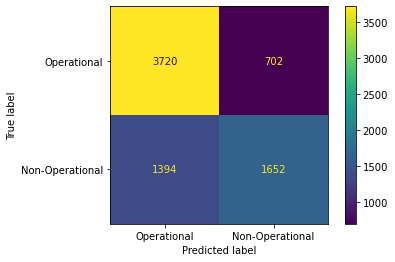

In [215]:
#Plot confusion matrix
plot_confusion_matrix(logreg, X_test_imputed_sc, y_test, 
                      display_labels=['Operational', 'Non-Operational']);

In [216]:
#Precision score using y_test predictions
y_test_pred = logreg.predict(X_test_imputed_sc)
#Using 'pos_label' bc positive variable corresponds to '0' not '1'
precision_score(y_test, y_test_pred, pos_label=0)

0.7274149393820883

In [217]:
#Instantiate new scorer using 'make_scorer'
scorer = make_scorer(precision_score, pos_label=0)

In [222]:
#Instantiate 'GridSearchCV' and list of parameters
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'solver' : ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [100000],    
}
clf = GridSearchCV(logreg, param_grid, cv=5, scoring=scorer)

In [223]:
#Fit the grid search to our training data
clf.fit(X_train_imputed_sc, y_train)
print(clf.best_params_)

{'C': 100, 'max_iter': 100000, 'solver': 'lbfgs'}


In [224]:
#Pass in the best parameters to new logistic regression 
logreg2 = LogisticRegression(random_state=33, C = 100, max_iter = 100000, solver= 'lbfgs' )

#Fit the new model to training data
logreg2.fit(X_train_imputed_sc, y_train)

LogisticRegression(C=100, max_iter=100000, random_state=33)

In [225]:
#Use 'cross_val_score' on training data to return corresponding precision score
cv_results = cross_val_score(estimator=logreg2, X=X_train_imputed_sc, y=y_train, cv=5, scoring=scorer)
cv_results

array([0.74541485, 0.74681393, 0.74935177, 0.74668945, 0.75163399])

In [226]:
#Precision score using test data and test predictions
y_test_pred = logreg2.predict(X_test_imputed_sc)
precision_score(y_test, y_test_pred, pos_label=0)

0.7279670975323149

In [227]:
#Use 'calassification_report' to summarize our scores
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      4422
           1       0.70      0.54      0.61      3046

    accuracy                           0.72      7468
   macro avg       0.71      0.69      0.70      7468
weighted avg       0.72      0.72      0.71      7468



In [228]:
#Predict our test probabilities
probas = logreg2.predict_proba(X_test_imputed_sc)[:, 1]
#Return the roc-auc score
roc_auc_score(y_test, probas)

0.7626597953941865

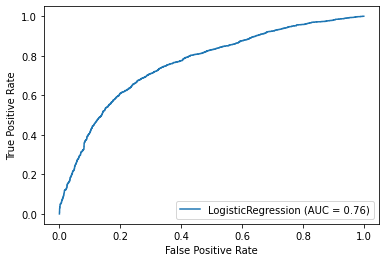

In [229]:
#Plot the ROC curve
plot_roc_curve(logreg2, X_test_imputed_sc, y_test);